In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold,RandomizedSearchCV
from ast import literal_eval
import ast
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import json
import warnings
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
train = pd.DataFrame()
test = pd.read_csv('test.csv')

In [3]:
#Shows the data type of each of the columns as well as the summary statistics of the numerical columns. 
display(df.columns)
display(df.describe())
display(df.info())

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

None

In [4]:
#Checks the percentage of missing values in each of the columns
display(df.isnull().sum()/len(df))

id                       0.000000
belongs_to_collection    0.798667
budget                   0.000000
genres                   0.002333
homepage                 0.684667
imdb_id                  0.000000
original_language        0.000000
original_title           0.000000
overview                 0.002667
popularity               0.000000
poster_path              0.000333
production_companies     0.052000
production_countries     0.018333
release_date             0.000000
runtime                  0.000667
spoken_languages         0.006667
status                   0.000000
tagline                  0.199000
title                    0.000000
Keywords                 0.092000
cast                     0.004333
crew                     0.005333
revenue                  0.000000
dtype: float64

In [37]:
nullhomerev = df.loc[df['homepage'].isnull(), 'revenue']
homerev = df.loc[df['homepage'].notnull(), 'revenue']
display(nullhomerev.describe())
display(homerev.describe())
hashomepage = np.array(df.homepage.isna(), dtype=int)

count    2.054000e+03
mean     4.216585e+07
std      7.474238e+07
min      1.000000e+00
25%      1.893915e+06
50%      1.232864e+07
75%      4.637010e+07
max      8.766885e+08
Name: revenue, dtype: float64

count    9.460000e+02
mean     1.200517e+08
std      2.091265e+08
min      1.000000e+00
25%      4.010988e+06
50%      3.545522e+07
75%      1.356870e+08
max      1.519558e+09
Name: revenue, dtype: float64

Text(0,0.5,'Revenue')

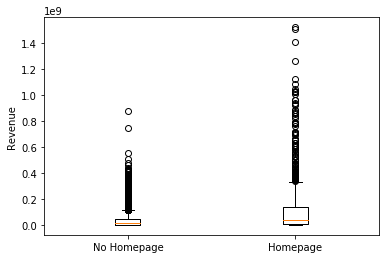

In [38]:
#We can see that the distriubtion of revenue for having a homepage is a lot more skewed to the right
#compared to not having a homepage. This could make a good feature because of that. 
plt.boxplot([nullhomerev,homerev],labels = ["No Homepage","Homepage"])
plt.ylabel("Revenue")

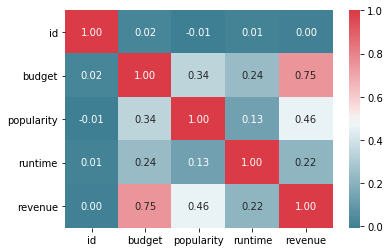

In [6]:
#We can see that the bugdet is highly corerlated with the revenue a movie will make
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=colormap, annot=True, fmt=".2f")


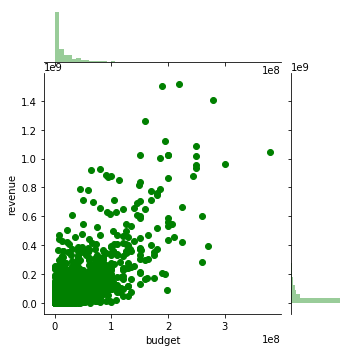

In [7]:
#The plot of bugdet to revenue looks strongly linearly correlated
sns.jointplot(x="budget", y="revenue", data=df, height=5, ratio=4, color="g")

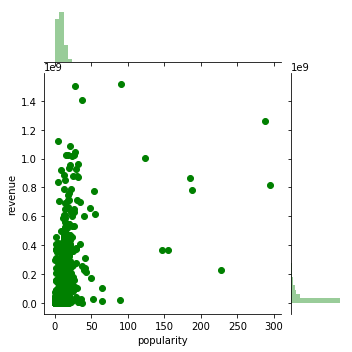

In [8]:
#The plot for popularity vs. revenue has a lot of outliers
sns.jointplot(x="popularity", y="revenue", data=df, height=5, ratio=4, color="g")

In [9]:
df['runtime'] = df['runtime'].fillna(np.mean(df['runtime']))

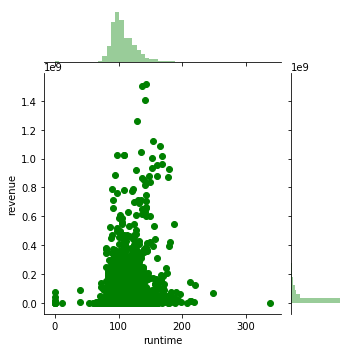

In [10]:
#the relationship with runtime and revenue is very ambiguous as a lot of movies neat the mean runtime 
#have very varied revenue
g = sns.jointplot(x='runtime', y="revenue", data=df, height=5, ratio=4, color="g")

In [11]:
#turns some of the columns that are json to lists for one hot encoding
def to_lists(df,col):
    dictionaries = df[col].apply(lambda x: {} if pd.isnull(x) else ast.literal_eval(x))
    for x in dictionaries.index:
        dictionaries[x] = [i['name'] for i in dictionaries[x]]
    df[col] = dictionaries

In [12]:
#Generates a one-hot encoding for the genres columns to be used as a feature
def genre_transform(df1,df2):
    genres= set()
    for genrelists in df1['genres']:    
        for x in genrelists:
            genres.add(x)
    for genre in genres:
        one_hot = [1 if genre in x else 0 for x in df1['genres']]
        df2[genre + ' one hot'] = one_hot

In [13]:
#one hot encodes the top n from a specified column
#for example if using the cast column, it would generate a one hot encoding for the top 20 most appearing actors
from collections import Counter
def list_one_hots(df,col,n,train):
    common = Counter([i for j in df[col] for i in j]).most_common(n)
    topNcompanies = [x for x,y in common]
    for N in topNcompanies:
        one_hot = [1 if N in x else 0 for x in df[col]]
        train[N + ' one hot'] = one_hot

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif,chi2
y = np.log(df['revenue'])

In [15]:
from datetime import datetime 
#fixes the date so features can be generated using the datetime package. 
def datefixer(x):
    split_array = x.split('/')
    if int(split_array[2]) <= 19:
        split_array[2] = '20' + split_array[2]
    else:
        split_array[2] = '19' + split_array[2]
    x = '/'.join(split_array)
    return x

In [16]:
#transforms the original dataframe into the feature matrix for training a model
def df_transform(df):
    output = pd.DataFrame()
    output['hashomepage'] = np.array(df.homepage.isna(), dtype=int)
    scaler = preprocessing.StandardScaler()
    output['budget'] = scaler.fit_transform(np.array(df['budget']).reshape(-1,1))
    #one hot encodes the top companies,cast members, genres and languages
    to_lists(df,'cast')
    to_lists(df,'production_companies')
    to_lists(df,'genres')
    to_lists(df,'spoken_languages')
    list_one_hots(df,'spoken_languages',5,output)
    output['num_spoken_languages']=df['spoken_languages'].apply(lambda x:len(x))
    list_one_hots(df,'cast',20,output)
    list_one_hots(df,'production_companies',20,output)
    genre_transform(df,output)
    #fixes the dates and each month one hot encoding
    df['release_date'] = df['release_date'].apply(lambda x: datefixer(x))
    df['release_date'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
    month_one_hot = pd.get_dummies(df['release_date'].apply(lambda x:x.month))
    for i in month_one_hot.columns:
        output['month_' + str(i)] = month_one_hot[i]
    return output

In [17]:
train = df_transform(df)

In [25]:
train.head()

,hashomepage,budget,English one hot,Français one hot,Español one hot,Deutsch one hot,Pусский one hot,num_spoken_languages,Samuel L. Jackson one hot,Robert De Niro one hot,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,-0.230453,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.471872,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,-0.519486,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,-0.576212,1,0,0,0,0,2,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,-0.608627,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#Generated a lgb dataset object and sets the hyperparameters to be used in the model
lgb_train = lgb.Dataset(train, y)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 100,
    'learning_rate': 0.09,
    'bagging_fraction': 0.1,
    'feature_fraction':.2,
    'lambda_l2':.5,
    'metric':'rmse',
    'eval_at':15
}

In [20]:
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                )
print('Starting predicting...')
y_pred = gbm.predict(train, num_iteration=759)
print('The rmse of prediction is:', mean_squared_error(y, y_pred) ** 0.5)

Starting training...
Starting predicting...
The rmse of prediction is: 1.6144839126379853


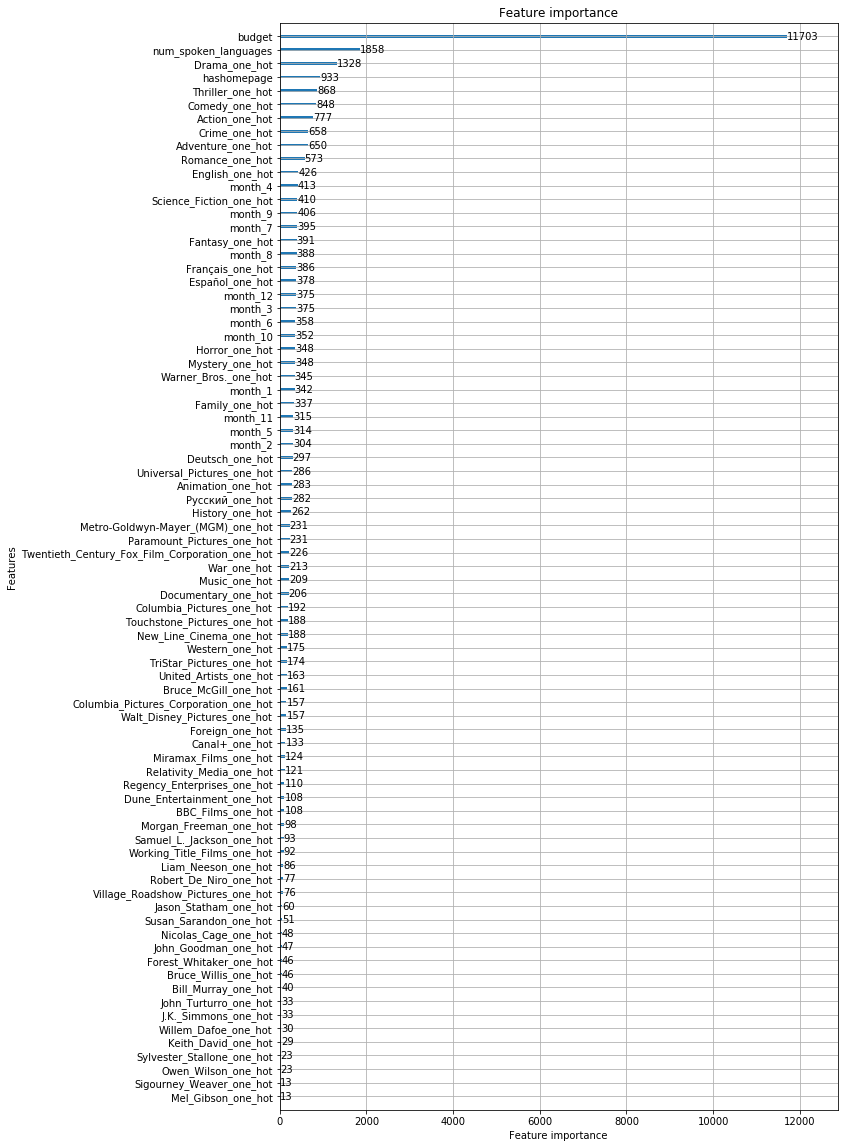

In [21]:
lgb.plot_importance(gbm,figsize = (10,20))

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub['revenue'] = np.expm1(gbm.predict(test_df))
sub.to_csv("submission.csv", index=False)

In [ ]:
len(param_test)